In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [7]:
# Creating a sample dataset
np.random.seed(42)
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(365)]  # One year of data
products = np.random.choice(['Mountain', 'Road', 'Hybrid'], size=365)
quantities = np.random.randint(5, 30, size=365)  # Daily sales
prices = np.random.normal(1, 0.1, size=365) * np.where(products == 'Mountain', 500, np.where(products == 'Road', 800, 650))

df = pd.DataFrame({
    'date_ordered': dates,
    'product': products,
    'quantity': quantities,
    'price': prices
})

# Aggregate data to weekly sales
df['week'] = df['date_ordered'].dt.to_period('W')
weekly_sales = df.groupby(['week', 'product']).agg({'quantity': 'sum', 'price': 'mean'}).reset_index()
weekly_sales['date_ordered'] = weekly_sales['week'].dt.start_time
weekly_sales = weekly_sales.drop('week', axis=1)
print(weekly_sales)

      product  quantity       price date_ordered
0      Hybrid        12  551.552635   2022-12-26
1      Hybrid        77  634.711431   2023-01-02
2    Mountain        63  526.850247   2023-01-02
3        Road         6  815.166794   2023-01-02
4      Hybrid        66  657.815858   2023-01-09
..        ...       ...         ...          ...
140    Hybrid        47  641.311964   2023-12-18
141  Mountain        54  455.410641   2023-12-18
142    Hybrid        37  596.179683   2023-12-25
143  Mountain        26  454.172709   2023-12-25
144      Road        59  883.361505   2023-12-25

[145 rows x 4 columns]


,bike_name,bike_type,date_ordered,quantity
0,AirMaster 300,BMX,2022-02-27,4
1,Hybrid Explorer,Hybrid Bike,2021-09-09,4
2,UrbanCommuter 500,Hybrid Bike,2023-08-31,10
3,AirMaster 300,BMX,2022-05-19,3
4,Roadmaster Pro,Road Bike,2023-12-17,1
...,...,...,...,...
95,Roadmaster Pro,Road Bike,2022-05-18,3
96,Mountain Climber XT,Mountain Bike,2021-06-01,8
97,TrailBlazer XT,Mountain Bike,2023-01-01,14
98,Speedster Pro,Road Bike,2021-06-15,5


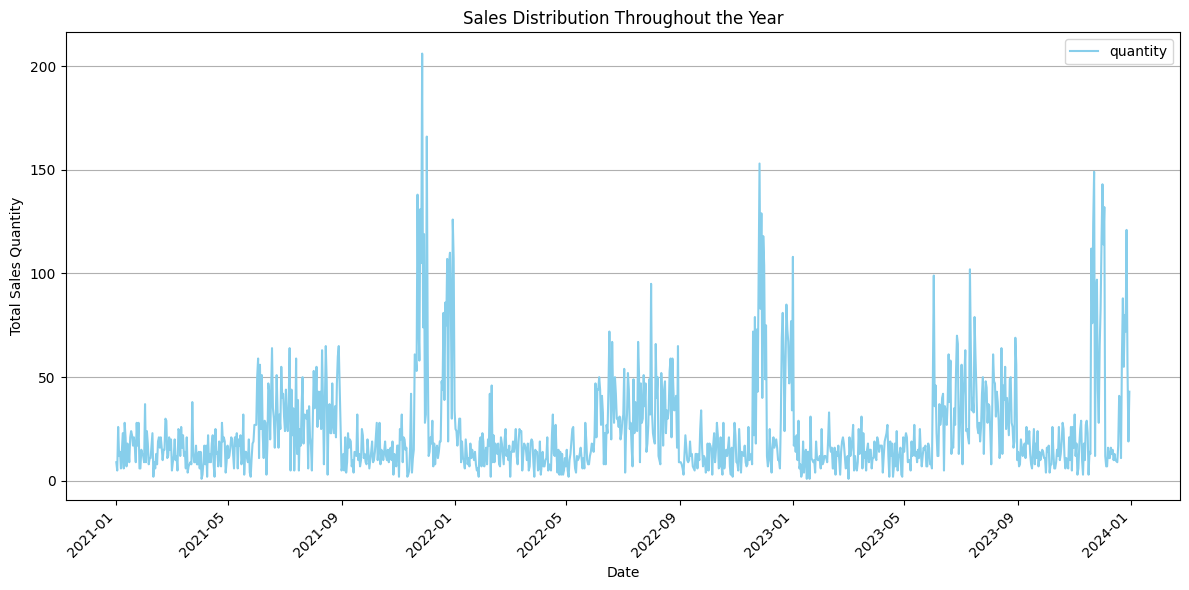

In [6]:
import matplotlib.pyplot as plt

def plot_sales_distribution(sales_data):
    sales_data['date_ordered'] = pd.to_datetime(sales_data['date_ordered'])
    
    # Group by date and sum the quantities
    daily_sales = sales_data.groupby('date_ordered')['quantity'].sum()
    
    plt.figure(figsize=(12, 6))
    daily_sales.plot(kind='line', color='skyblue')  # Continuous line plot for daily sales
    plt.title('Sales Distribution Throughout the Year')
    plt.xlabel('Date')
    plt.ylabel('Total Sales Quantity')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # # Create a custom legend for months
    # plt.axvline(pd.to_datetime('2021-01-01'), color='gray', linestyle='--', label='Jan')
    # plt.axvline(pd.to_datetime('2021-02-01'), color='gray', linestyle='--', label='Feb')
    # plt.axvline(pd.to_datetime('2021-03-01'), color='gray', linestyle='--', label='Mar')
    # plt.axvline(pd.to_datetime('2021-04-01'), color='gray', linestyle='--', label='Apr')
    # plt.axvline(pd.to_datetime('2021-05-01'), color='gray', linestyle='--', label='May')
    # plt.axvline(pd.to_datetime('2021-06-01'), color='gray', linestyle='--', label='Jun')
    # plt.axvline(pd.to_datetime('2021-07-01'), color='gray', linestyle='--', label='Jul')
    # plt.axvline(pd.to_datetime('2021-08-01'), color='gray', linestyle='--', label='Aug')
    # plt.axvline(pd.to_datetime('2021-09-01'), color='gray', linestyle='--', label='Sep')
    # plt.axvline(pd.to_datetime('2021-10-01'), color='gray', linestyle='--', label='Oct')
    # plt.axvline(pd.to_datetime('2021-11-01'), color='gray', linestyle='--', label='Nov')
    # plt.axvline(pd.to_datetime('2021-12-01'), color='gray', linestyle='--', label='Dec')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the sales distribution
plot_sales_distribution(sales_dataset)



In [21]:

# try:
#     # For newer versions of scikit-learn
#     column_transformer = ColumnTransformer([
#         ('ohe', OneHotEncoder(sparse_output=False), ['bike_name']),
#         ('scaler', StandardScaler(), ['quantity', 'price'])
#     ])
# except TypeError:
#     # For older versions of scikit-learn
#     column_transformer = ColumnTransformer([
#         ('ohe', OneHotEncoder(sparse=False), ['bike_name']),
#         ('scaler', StandardScaler(), ['quantity', 'price'])
#     ])
# Update the ColumnTransformer to use the correct column names
try:
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(sparse_output=False), ['bike_type']),  # Change 'product' to 'bike_type'
        ('scaler', StandardScaler(), ['quantity'])  # Keep 'quantity' as it is
    ])
    
    # Fit and transform the data
    data = column_transformer.fit_transform(sales_dataset)
except Exception as e:
    print(f"Error occurred: {e}")

# Fit and transform the data
# print(sales_dataset.head())
data = column_transformer.fit_transform(sales_dataset)
# print("ghh")
# print("ghh")
# print("ghh")
n_features = data.shape[1]

# Create sequences (use last 4 weeks to predict the next week)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        end_ix = i + n_steps
        seq_x = data[i:end_ix]
        seq_y = data[end_ix, 1:4]  # Predict quantities for all 3 products
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 4
X, y = create_sequences(data, n_steps)
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X test")
print(X_test)
# Model definition
model = Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Output layer with 3 units (one for each product)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Model evaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test)
print('predicc')
print('predicc')
print('predicc')
print(predictions)


           bike_name    bike_type date_ordered  quantity
0      AirMaster 300          BMX   2022-02-27         4
1    Hybrid Explorer  Hybrid Bike   2021-09-09         4
2  UrbanCommuter 500  Hybrid Bike   2023-08-31        10
3      AirMaster 300          BMX   2022-05-19         3
4     Roadmaster Pro    Road Bike   2023-12-17         1
ghh
ghh
ghh
X test
[[[ 0.          0.          0.          1.         -0.99221495]
  [ 0.          0.          0.          1.         -0.99221495]
  [ 0.          0.          1.          0.         -0.5203159 ]
  [ 0.          0.          1.          0.          3.01892702]]

 [[ 0.          1.          0.          0.         -0.5203159 ]
  [ 0.          0.          0.          1.         -0.5203159 ]
  [ 1.          0.          0.          0.          2.78297749]
  [ 1.          0.          0.          0.          2.31107843]]

 [[ 1.          0.          0.          0.         -0.99221495]
  [ 0.          1.          0.          0.         -0.04841

In [31]:
# def inverse_transform_predictions(column_transformer, X_test, predictions):
#     # Get the OneHotEncoder and StandardScaler from the ColumnTransformer
#     ohe = column_transformer.named_transformers_['ohe']
#     scaler = column_transformer.named_transformers_['scaler']
    
#     print(f"Shape of X_test: {X_test.shape}")
#     print(f"Shape of predictions: {predictions.shape}")
    
#     # Inverse transform the one-hot encoded product
#     product_inverse = ohe.inverse_transform(X_test[:, -1, :3])
#     print(f"Shape of product_inverse: {product_inverse.shape}")
    
#     # Inverse transform the scaled quantities
#     try:
#         quantities_inverse = scaler.inverse_transform(predictions)
#         print(f"Shape of quantities_inverse: {quantities_inverse.shape}")
#     except ValueError as e:
#         print(f"Error in inverse_transform: {e}")
#         print(f"Shape of scaler.scale_: {scaler.scale_.shape}")
#         print(f"Shape of scaler.mean_: {scaler.mean_.shape}")
    
#     # For debugging, return the shapes
#     return {
#         'X_test_shape': X_test.shape,
#         'predictions_shape': predictions.shape,
#         'product_inverse_shape': product_inverse.shape,
#     }

# # Use the updated function
# debug_info = inverse_transform_predictions(column_transformer, X_test, predictions)
# print("Debug info:", debug_info)

In [30]:
# def inverse_transform_predictions(column_transformer, X_test, predictions, dates):
#     # Get the OneHotEncoder and StandardScaler from the ColumnTransformer
#     ohe = column_transformer.named_transformers_['ohe']
#     scaler = column_transformer.named_transformers_['scaler']
    
#     # Inverse transform the one-hot encoded product
#     product_inverse = ohe.inverse_transform(X_test[:, -1, :3])
    
#     # Inverse transform the scaled quantities
#     quantities_inverse = predictions * scaler.scale_[0] + scaler.mean_[0]
    
#     # Combine the results
#     result = []
#     for date, prods, quants in zip(dates, product_inverse, quantities_inverse):
#         result.extend((date, prod, quant) for prod, quant in zip(prods, quants))
    
#     return np.array(result, dtype=object)

# # Assuming you have a dates array corresponding to your predictions
# # If not, you'll need to create this based on your data
# dates = pd.date_range(start='2023-01-01', periods=len(predictions), freq='W')

# # Use the updated function
# predictions_original_scale = inverse_transform_predictions(column_transformer, X_test, predictions, dates)

# print("Sample predictions (date, product, quantity):")
# for date, product, quantity in predictions_original_scale[:15]:
#     print(f"{date.strftime('%Y-%m-%d')}: {product}: {float(quantity):.0f}")

# # Additional debugging information
# print("\nShape of predictions_original_scale:", predictions_original_scale.shape)

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime

def get_potential_influence(date):
    """Determine potential influences based on the date."""
    month = date.month
    day = date.day
    
    if month == 12 or (month == 1 and day <= 7):
        return "Christmas/New Year"
    elif month == 11 and day >= 20:
        return "Black Friday/Cyber Monday"
    elif 3 <= month <= 5:
        return "Spring Season"
    elif (month==6 and day>25) or (month==7):
        return "Tour de France"
    elif 6 <= month <= 8:
        return "Summer Season"
    elif month == 9:
        return "Back to School"
    else:
        return "No major influence"

def inverse_transform_predictions(column_transformer, X_test, predictions, dates):
    # Get the OneHotEncoder and StandardScaler from the ColumnTransformer
    ohe = column_transformer.named_transformers_['ohe']
    scaler = column_transformer.named_transformers_['scaler']
    
    # Inverse transform the one-hot encoded product
    product_inverse = ohe.inverse_transform(X_test[:, -1, :4])
    
    # Inverse transform the scaled quantities
    quantities_inverse = predictions * scaler.scale_[0] + scaler.mean_[0]
    
    # Combine the results
    result = []
    for date, prods, quants in zip(dates, product_inverse, quantities_inverse):
        influence = get_potential_influence(date)
        result.extend((date, prod, quant, influence) for prod, quant in zip(prods, quants))
    
    return np.array(result, dtype=object)

# Assuming you have a dates array corresponding to your predictions
# If not, you'll need to create this based on your data
dates = pd.date_range(start='2023-01-01', periods=len(predictions), freq='W')

# Use the updated function
predictions_original_scale = inverse_transform_predictions(column_transformer, X_test, predictions, dates)

print("Sample predictions (date_ordered, bike_name, quantity, potential_influence):")
for date, bike_name, quantity, influence in predictions_original_scale[:15]:
    print(f"{date.strftime('%Y-%m-%d')}: {bike_name}: {float(quantity):.0f} - {influence}")

# Additional debugging information
print("\nShape of predictions_original_scale:", predictions_original_scale.shape)

print('==================')
print('==================')
print('==================')
print('==================')
print('==================')
print(predictions_original_scale[:5])

Sample predictions (date_ordered, bike_name, quantity, potential_influence):
2023-01-01: Mountain Bike: 7 - Christmas/New Year
2023-01-08: BMX: 8 - No major influence
2023-01-15: BMX: 6 - No major influence
2023-01-22: BMX: 6 - No major influence
2023-01-29: BMX: 6 - No major influence
2023-02-05: Road Bike: 6 - No major influence
2023-02-12: Road Bike: 6 - No major influence
2023-02-19: BMX: 6 - No major influence
2023-02-26: Mountain Bike: 6 - No major influence
2023-03-05: BMX: 6 - Spring Season
2023-03-12: Hybrid Bike: 6 - Spring Season
2023-03-19: Mountain Bike: 6 - Spring Season
2023-03-26: Mountain Bike: 7 - Spring Season
2023-04-02: Mountain Bike: 6 - Spring Season
2023-04-09: Mountain Bike: 7 - Spring Season

Shape of predictions_original_scale: (1000, 4)
[[Timestamp('2023-01-01 00:00:00') 'Mountain Bike' 6.5225625
  'Christmas/New Year']
 [Timestamp('2023-01-08 00:00:00') 'BMX' 7.5929656 'No major influence']
 [Timestamp('2023-01-15 00:00:00') 'BMX' 6.0026727 'No major influe

In [35]:
import pandas as pd

# Assuming predictions_original_scale is a numpy array with the structure:
# (date, product, quantity, influence)
# Convert to DataFrame
predictions_df = pd.DataFrame(predictions_original_scale, columns=['date', 'bike_name', 'quantity', 'influence'])

# Convert 'date' column to datetime
predictions_df['date'] = pd.to_datetime(predictions_df['date'])

# Group by year and week, summing the quantities
weekly_summary = predictions_df.groupby([predictions_df['date'].dt.year, predictions_df['date'].dt.isocalendar().week,predictions_df['bike_name']])['quantity'].sum().reset_index()

# Rename columns for clarity
weekly_summary.columns = ['year', 'week','bike_name', 'total_quantity']

# Display the grouped DataFrame
print(weekly_summary)

     year  week      bike_name total_quantity
0    2023     1            BMX       7.592966
1    2023     2            BMX       6.002673
2    2023     3            BMX       6.484437
3    2023     4            BMX       6.115802
4    2023     5      Road Bike       6.113373
..    ...   ...            ...            ...
993  2042     4  Mountain Bike       5.978385
994  2042     5      Road Bike       6.417285
995  2042     6    Hybrid Bike       7.517942
996  2042     7      Road Bike       6.309374
997  2042     8  Mountain Bike        7.44453

[998 rows x 4 columns]
